![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Running Hype model using eWaterCycle package

This notebook shows how to run [Hype](http://www.smhi.net/hype/wiki/doku.php?id=start) model using a demo use-case.

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd

import ewatercycle.models
import ewatercycle.parameter_sets

## Load parameter set

The parameter set `demo.zip` should be downloaded from https://sourceforge.net/projects/hype/files/release_hype_5_6_2/ and unzipped.


In [2]:
parameter_set_dir = "<path where demo.zip was extracted to>"
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="hype_demo",
    directory=parameter_set_dir,
    config="info.txt",
    target_model="hype",
)

## Setting up the model

Note that the model version and the parameterset versions should be compatible.

In [3]:
ewatercycle.models.Hype.available_versions

('feb2021',)

In [4]:
model = ewatercycle.models.Hype(version="feb2021", parameter_set=parameter_set)

eWaterCycle exposes a selected set of configurable parameters. These can be modified in the `setup()` method.

In [5]:
model.parameters

[('start_time', '1961-01-01T00:00:00Z'),
 ('end_time', '1963-12-31T00:00:00Z'),
 ('crit_time', '1962-01-01T00:00:00Z')]

Calling `setup()` will start up a container. Be careful with calling it multiple times!

In [6]:
cfg_file, cfg_dir = model.setup(end_time="1962-06-30T00:00:00Z")
cfg_file, cfg_dir

('/tmp/hype_20220607_121055/info.txt', '/tmp/hype_20220607_121055')

In [7]:
model.parameters

[('start_time', '1961-01-01T00:00:00Z'),
 ('end_time', '1962-06-30T00:00:00Z'),
 ('crit_time', '1962-01-01T00:00:00Z')]

Note that the parameters have been changed. A new config file which incorporates these updated parameters has been generated as well. If you want to see or modify any additional model settings, you can acces this file directly. When you're ready, pass the path to the config file to `initialize()`.

In [8]:
model.initialize(cfg_file)

## Running the model

Simply running the model from start to end is straightforward. At each time step we can retrieve information from the model.

In [9]:
discharge = []
time_range = []
end_time = model.end_time

while model.time < end_time:
    model.update()
    # The demo parameter set has a single sub catchment so store first value of array
    discharge.append(model.get_value("comp outflow olake")[0])
    time_range.append(model.time_as_datetime.date())
    print(model.time_as_isostr, end="\r")

## Interacting with the model

Hype model exposes many variables.

In [10]:
model.output_var_names

('comp outflow olake',
 'rec outflow olake',
 'air temperature',
 'corrected air temper',
 'precipitation',
 'corr precipitation',
 'subbasin evaporation',
 'computed runoff',
 'computed soil water')

Hype is a lumped sub-basin model so there are values per subbasin. The outflow of all sub-basins can be requested with:

In [11]:
da = model.get_value("comp outflow olake")
da

array([6.71861417e-05])

The model has some info about the sub-basins:

In [12]:
[
    model.bmi.get_grid_size(1),
    model.bmi.get_grid_rank(1),
    model.bmi.get_grid_type(1),
    model.bmi.get_grid_shape(1),
    model.bmi.get_grid_x(1),
    model.bmi.get_grid_y(1),
]

[1, 1, 'unstructured', (1,), array([0.]), array([0.])]

## Inspect the results

In [17]:
simulated_discharge = pd.DataFrame(
    {"simulation": discharge}, index=pd.to_datetime(time_range)
)

<AxesSubplot:>

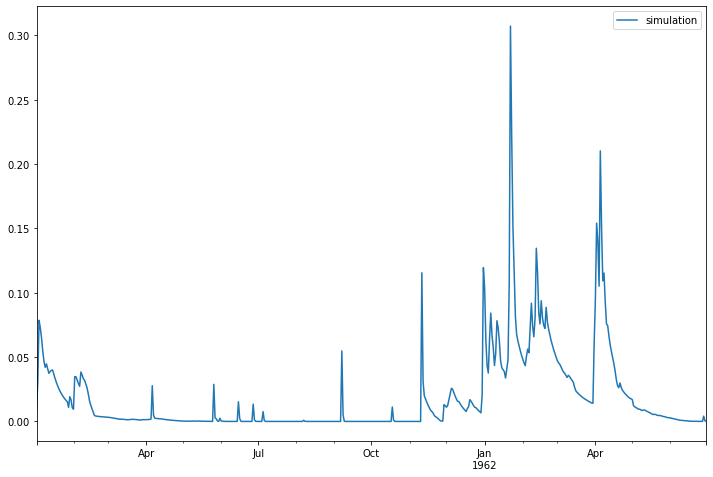

In [18]:
simulated_discharge.plot(figsize=(12, 8))

## Cleaning up

Models usually perform some "wrap up tasks" at the end of a model run, such as writing the last outputs to disk and releasing memory. In the case of eWaterCycle, another important teardown task is destroying the container in which the model was running. This can free up a lot of resources on your system. Therefore it is good practice to always call `finalize()` when you're done with an experiment.

In [10]:
model.finalize()